# Trainable activation layer implementations

In [ ]:
class LayerActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(LayerActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, *([1] * len(input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class KernelActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(KernelActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(KernelActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    # Is conv layer
    if len(input_shape) > 2:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape[:-1])), input_shape[-1]),
          initializer="zeros",
          trainable=True,
      )
    # Is regular layer
    else:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape))),
          initializer="zeros",
          trainable=True,
      )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class NeuronActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(NeuronActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(NeuronActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, 1, *list(map(lambda shape: shape if shape is not None else 1, input_shape[1:]))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

# Functions

## Model saving functions

In [ ]:
import pickle

def save_history(filepath, history):
  try:
    filepath = filepath + '.history.pickle'
    print("Saving history to", filepath)
    pickle.dump(history, open(filepath, 'wb'))
  except Exception as e:
    print(e)

def load_history(filepath):
  try:
    filepath = filepath + '.history.pickle'
    return pickle.load(open(filepath, 'rb'))
  except Exception as e:
    print(e)

In [ ]:
def load_model(filepath):
  custom_objects = {"LayerActivationWoSoftmax": LayerActivationWoSoftmax, "LayerActivation": LayerActivation, "NeuronActivation": NeuronActivation, "KernelActivation": KernelActivation}
  with keras.utils.custom_object_scope(custom_objects):
    return models.load_model(filepath)

def load_models(filepath, epochs):
  models_list = []
  for epoch in epochs:
    models_list.append(load_model(filepath.format(epoch=epoch)))
  return models_list

def load_models_from_weights(model, filepath, epochs):
  models_list = []
  for epoch in epochs:
    cloned_model = models.clone_model(model)
    cloned_model.load_weights(filepath.format(epoch=epoch))
    models_list.append(cloned_model)
  return models_list

# Analysis

In [ ]:
from os import listdir
from os.path import isfile, join
import re
import sys

from matplotlib import pyplot as plt

In [ ]:
def get_history(models_path):
    models_files = list(filter(lambda file: re.match("model-epoch-(.*)-acc-(.*)-val_acc-(.*).hdf5", file), listdir(models_path))) if os.path.isdir(models_path) else []
    history = []
    for file in models_files:
        match = re.match("model-epoch-(.*)-acc-(.*)-val_acc-(.*).hdf5", file)
        history.append((int(match.group(1)), float(match.group(2)), float(match.group(3))))
    history.sort(key=lambda x: x[0])
    epochs = list(map(lambda x: x[0], history))
    accs = list(map(lambda x: x[1], history))
    val_accs = list(map(lambda x: x[2], history))
    return epochs, accs, val_accs

In [ ]:
def load_model_(models_path):
    models_files = list(filter(lambda file: re.match("model-epoch-(.*)-acc-(.*)-val_acc-(.*).hdf5", file), listdir(models_path))) if os.path.isdir(models_path) else []
    if models_files:
        furthest_model = max(
            models_files,
            key=lambda file: (lambda file, fn: fn(re.match("model-epoch-(.*)-acc-(.*)-val_acc-(.*).hdf5", file)))(file, lambda match: int(match.group(1)) if match is not None else -1)
        )
        epochs_ran = int(re.match("model-epoch-(.*)-acc-(.*)-val_acc-(.*).hdf5", furthest_model).group(1))
        model = load_model(models_path + '/' + furthest_model)
        return model

In [ ]:
def is_activation_layer(layer):
  return 'activation' in layer.get_config()['name'] and layer.get_config().get('activation_functions', False)

In [ ]:
import math

def plot_activation_function_bars(layer):
  config = layer.get_config()

  if "wo_softmax" in layer.get_config()['name']:
    weights = tf.convert_to_tensor(layer.get_weights())
  else:
    weights = keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()), axis=1)

  plt.tight_layout()
  labels = list(map(lambda fn: keras.activations.serialize(fn)[:8], layer.activation_functions))
  index = tuple([0, slice(None)] + [0] * (len(weights.shape) - 2))
  plt.xticks(rotation=45, ha="right")
  plt.ylim(0, 1.0)
  plt.bar(labels, weights[index])

def plot_activation_functions_bars(models, width=10, height=4, mode='grid', n=6, m=4):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  width = width * len(models) # width - for each model / epoch
  height = height * len([layer for layer in models[0].layers if is_activation_layer(layer)]) # height - for each layer

  plt.figure(figsize=(width, height), dpi=300)
  count = 0
  for i, model in enumerate(models):
    activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
    for j, layer in enumerate(activation_layers):
      if mode == 'grid':
        plt.subplot(n, m, count + 1)
      else:
        plt.subplot(len(activation_layers), len(models), count + 1)
      plot_activation_function_bars(layer)
      plt.title(f'Activation layer {j + 1}')
      # plt.title(f'Model {i + 1} Layer {layer.get_config()["name"]}')
      count += 1

  plt.show()

In [ ]:
def plot_performance(history, val_acc_label='Test accuracy', test_accuracy=None):
  plt.figure(figsize=(9,5), dpi=300)
  plt.grid(visible=True, axis='both', which='both')
  plt.yticks(np.arange(0.1, 1.1, 0.1))
  if history:
    # In case of val training
    if type(history) is list:
      epochs = range(1, len(history) + 1)
      accuracy = [metric['accuracy'] for metric in history]
      plt.plot(epochs, accuracy, label='Train accuracy')

      if 'val_accuracy' in history[0]:
        val_accuracy = [metric['val_accuracy'] for metric in history]
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
    # Regular training
    else:
      epochs = range(1, len(history.history['accuracy']) + 1)
      plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 1))
      plt.plot(epochs, history.history['accuracy'], label='Train accuracy')
      plt.plot(epochs, history.history['val_accuracy'], label = val_acc_label)
    if test_accuracy:
      plt.axhline(y=test_accuracy, label='Test accuracy', color='r', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
  else:
    print("Could not plot performance: history not available")

In [ ]:
def plot_activation_function(layer, x_start, x_end, n=None):
  config = layer.get_config()
  x = np.arange(x_start * 10, x_end * 10) / 10
  initial_x_len = x.shape[0]
  x = x.reshape(tuple([x.shape[0]] + [1] * (len(layer.weights[0].shape) - 2)))
  y = np.array(layer(x))
  plt.tight_layout()
  plt.ylim(-10, 20)
  plt.plot(x.reshape(initial_x_len), y.reshape(initial_x_len))
  if n is None:
    plt.title(config['name'])
  else:
    plt.title(f'Activation layer {n + 1}')


def plot_activation_functions(models, x_start=-20, x_end=20, width=4, height=2, mode=None):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
  n_activation_layers = len(activation_layers)
  plt.figure(figsize=(width * len(models), height * n_activation_layers), dpi=300)
  count = 0
  for model in models:
    activation_layers = [layer for layer in model.layers if is_activation_layer(layer)]
    for i, layer in enumerate(activation_layers):
      count += 1
      if mode == 'grid':
        plt.subplot(6, 4, count)
      else:
        plt.subplot(n_activation_layers, len(models), count)
      plot_activation_function(layer, x_start, x_end, i)
  plt.show()

In [ ]:
def get_max_accuracy(history):
  if type(history) == list:
    max_test_acc = max(history, key=lambda x: x['val_accuracy'])['val_accuracy'].numpy()
    max_train_acc = max(history, key=lambda x: x['accuracy'])['accuracy'].numpy()
  else:
    max_test_acc = max(history.history['val_accuracy'])
    max_train_acc = max(history.history['accuracy'])

  return {'accuracy': max_train_acc, 'val_accuracy': max_test_acc}

In [ ]:
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
models_path = "drive/MyDrive/master-thesis/models/experiments-imagenet/"
listdir(models_path)

['layer-5-model-epoch-80.hdf5',
 'layer-3-model-epoch-80.hdf5',
 'relu-model-epoch-80.hdf5']

In [ ]:
model_relu = load_model(models_path + 'relu-model-epoch-80.hdf5')
model_layer_1 = load_model(models_path + 'layer-3-model-epoch-80.hdf5')
model_layer_2 = load_model(models_path + 'layer-5-model-epoch-80.hdf5')
history_relu = get_history('./models/resnet-imagenet-relu')
history_layer_1 = get_history('./models/resnet-imagenet-layer-3')
history_layer_2 = get_history('./models/resnet-imagenet-layer-5')

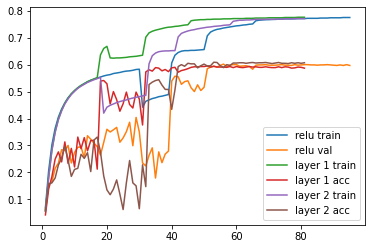

In [ ]:
plt.plot(history_relu[0], history_relu[1], label='relu train')
plt.plot(history_relu[0], history_relu[2], label='relu val')
plt.plot(history_layer_1[0], history_layer_1[1], label='layer 1 train')
plt.plot(history_layer_1[0], history_layer_1[2], label='layer 1 acc')
plt.plot(history_layer_2[0], history_layer_2[1], label='layer 2 train')
plt.plot(history_layer_2[0], history_layer_2[2], label='layer 2 acc')
plt.legend()

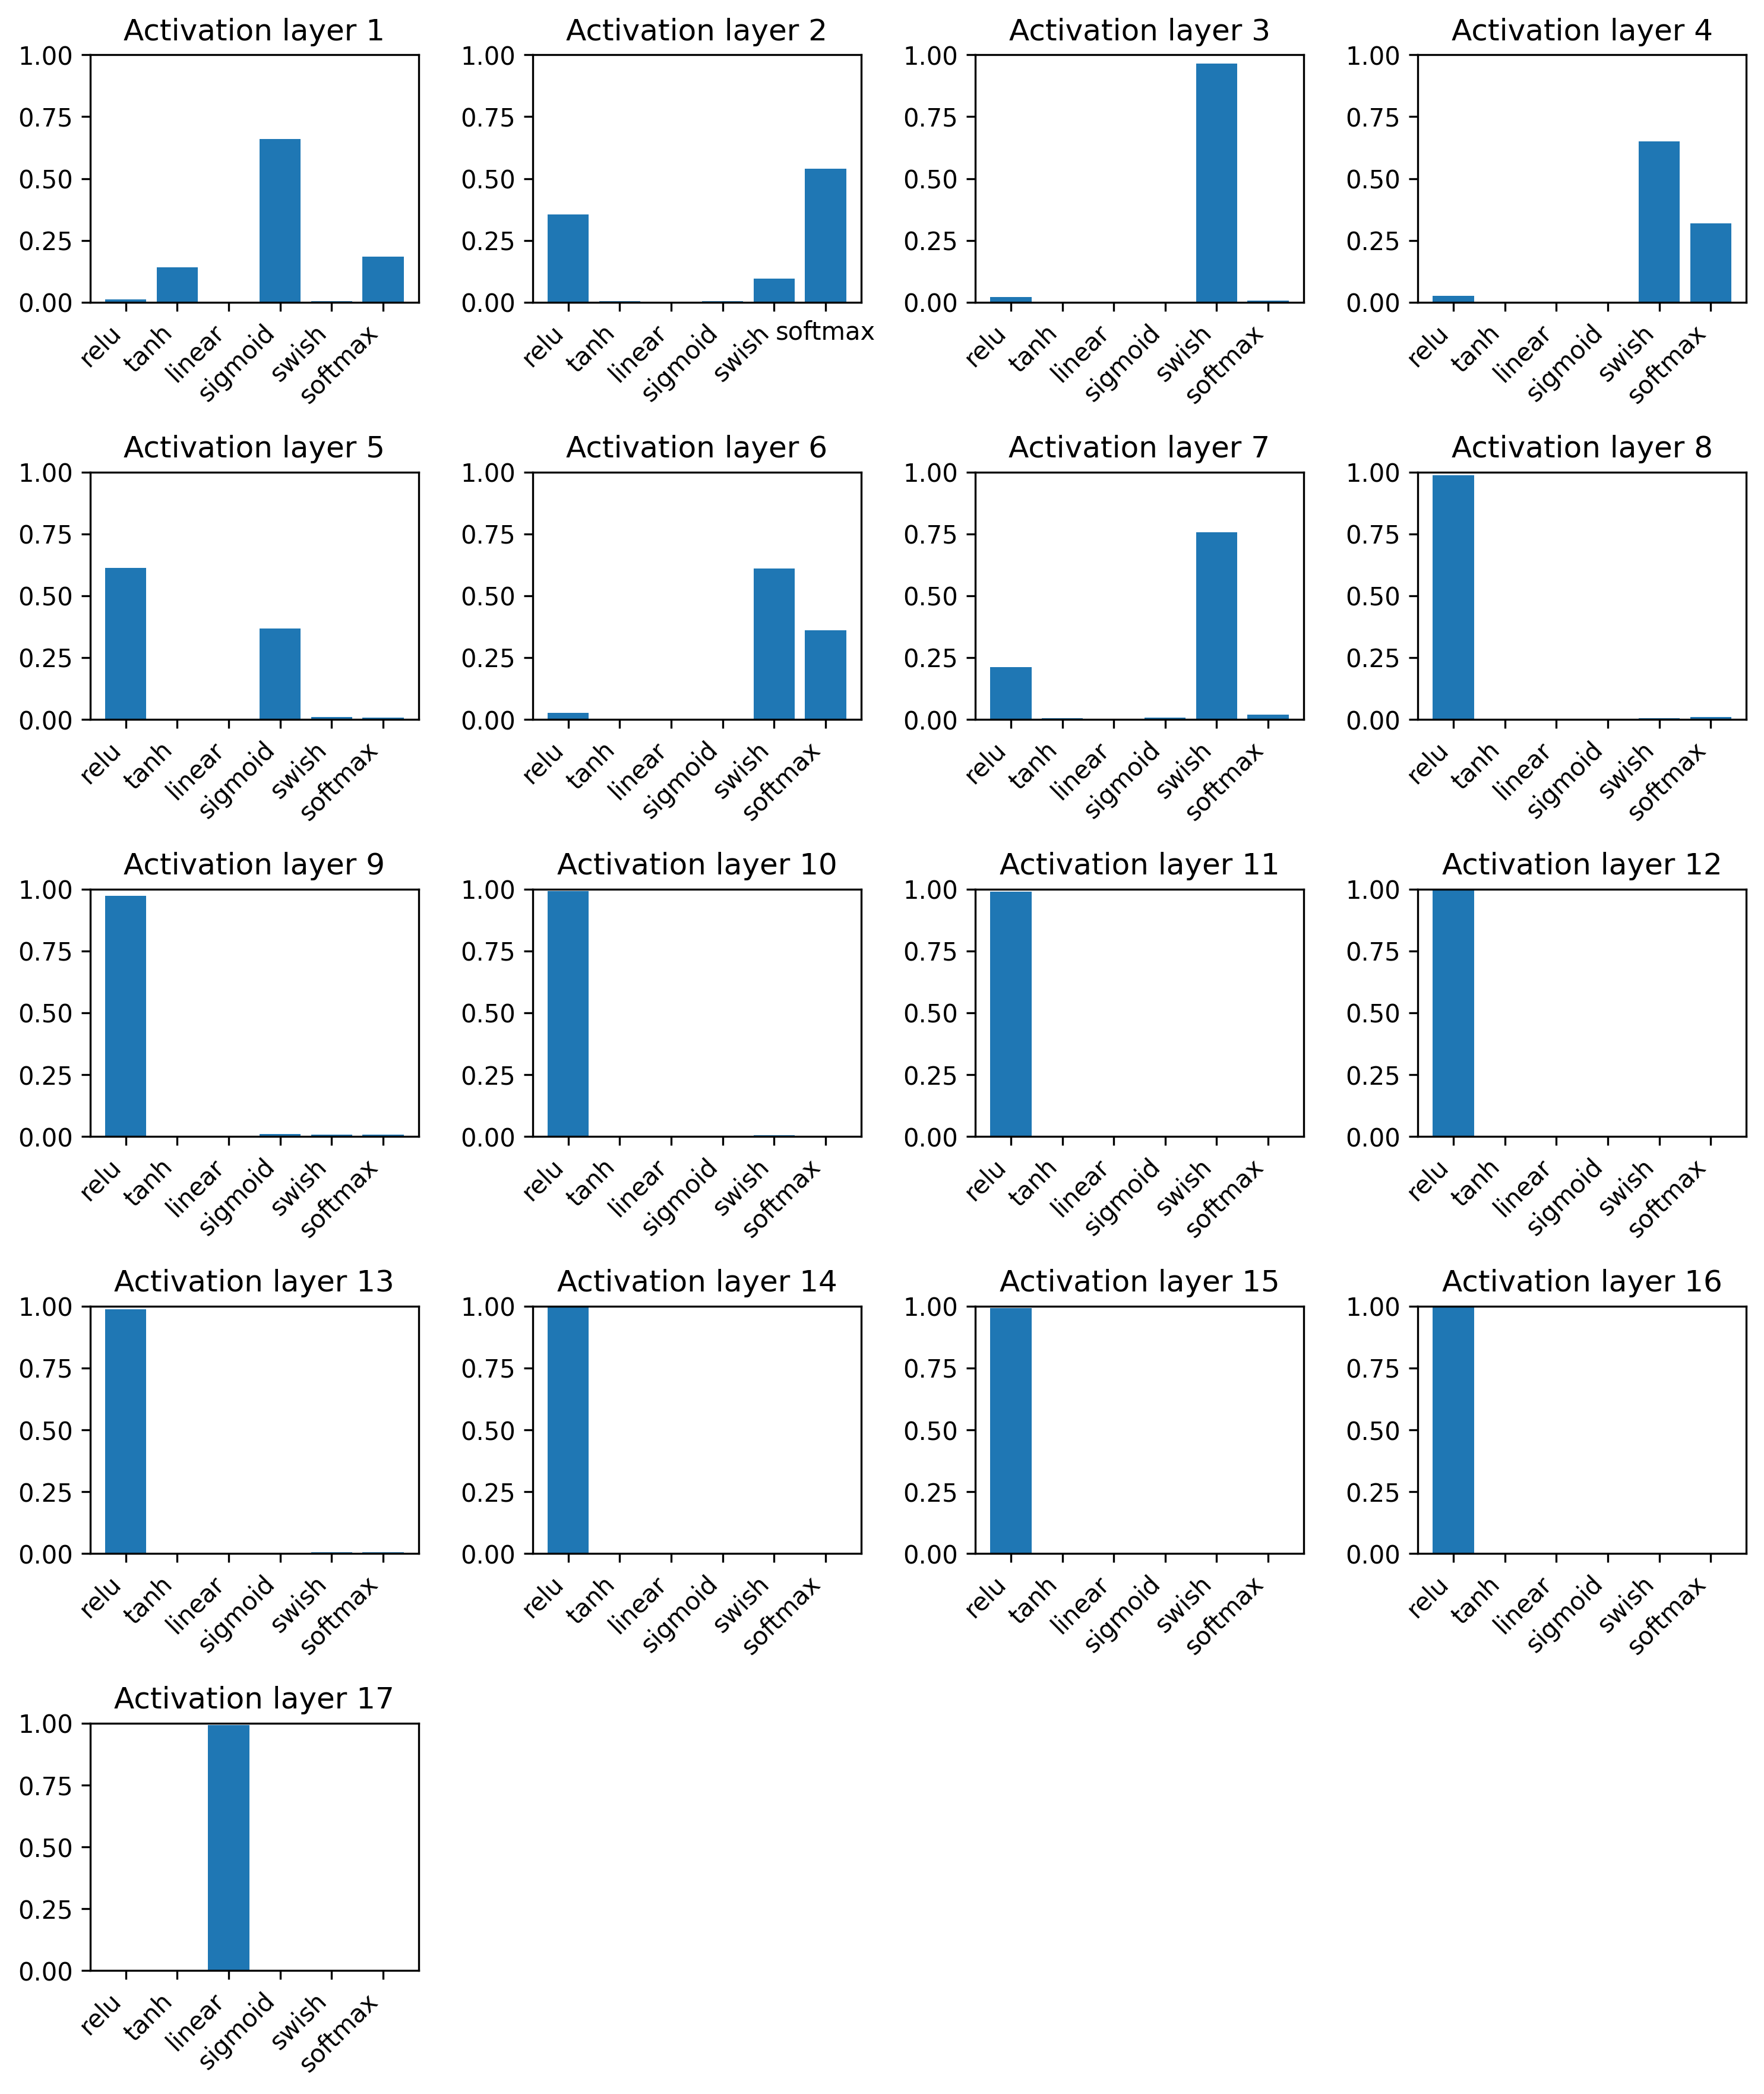

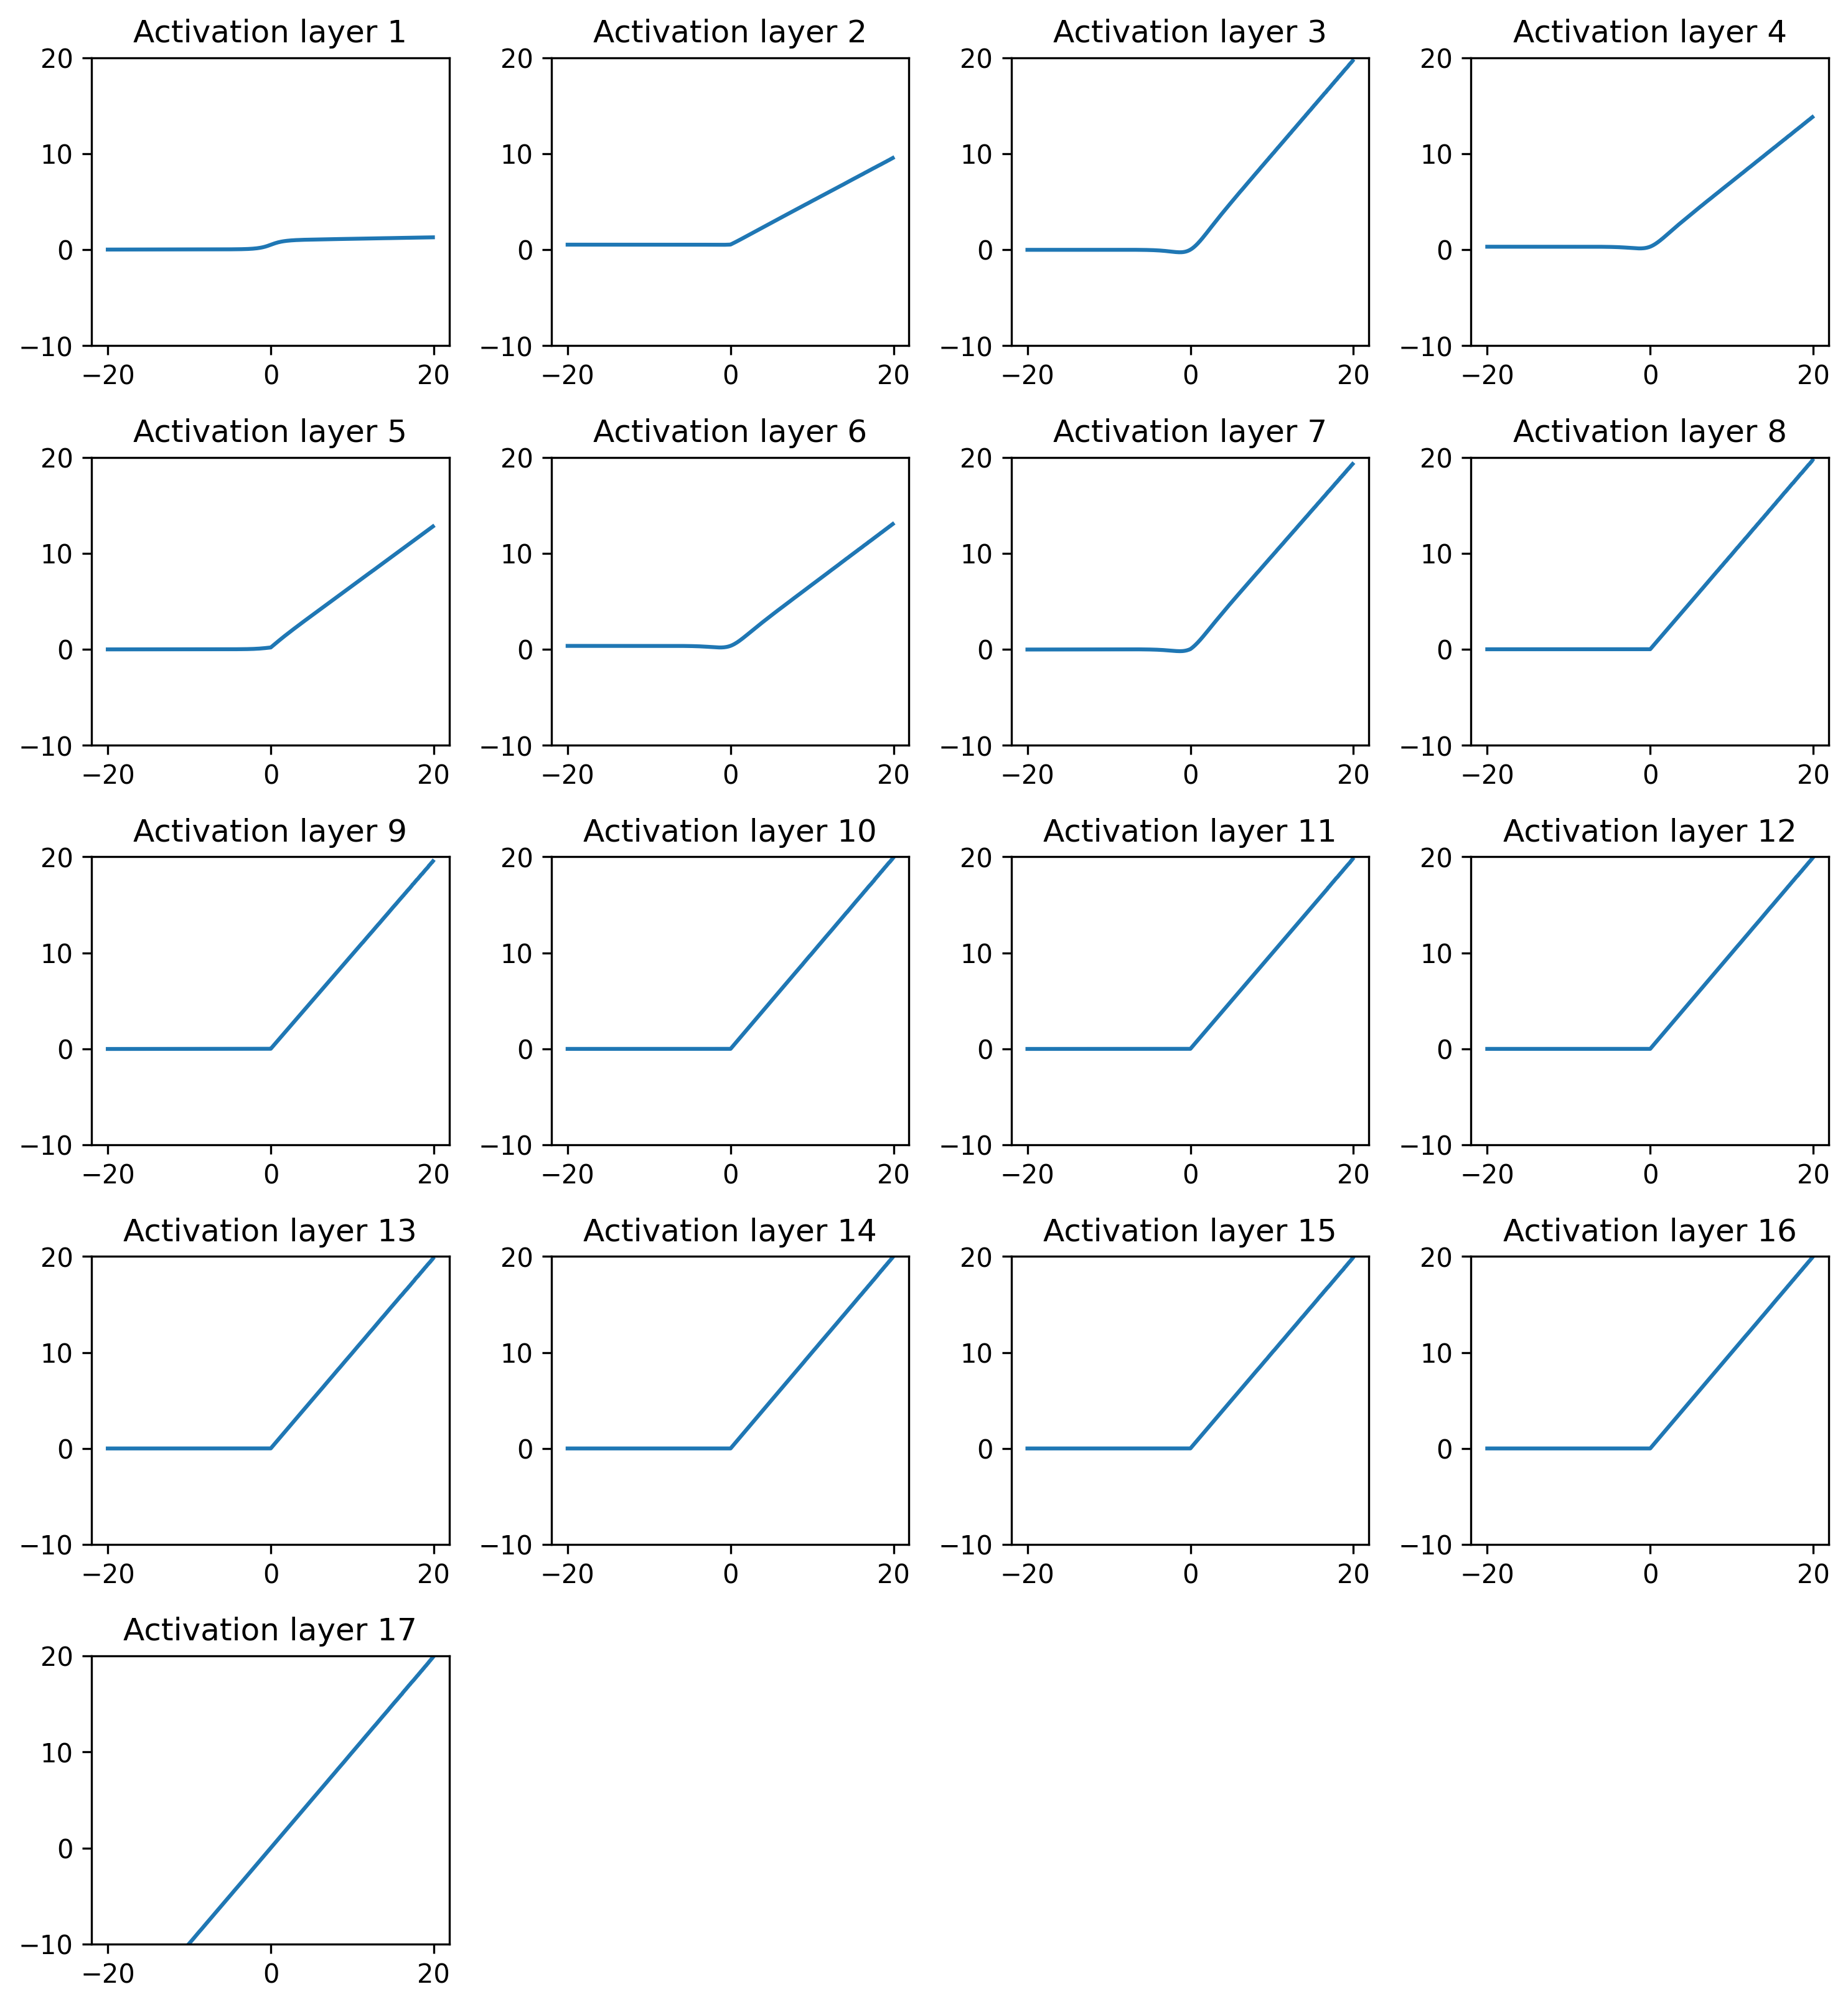

In [ ]:
plot_activation_functions_bars([model_layer_1.layers[3]], width=10, height=0.8, mode='grid')
plot_activation_functions([model_layer_1.layers[3]], width=10, height=0.75, mode='grid')

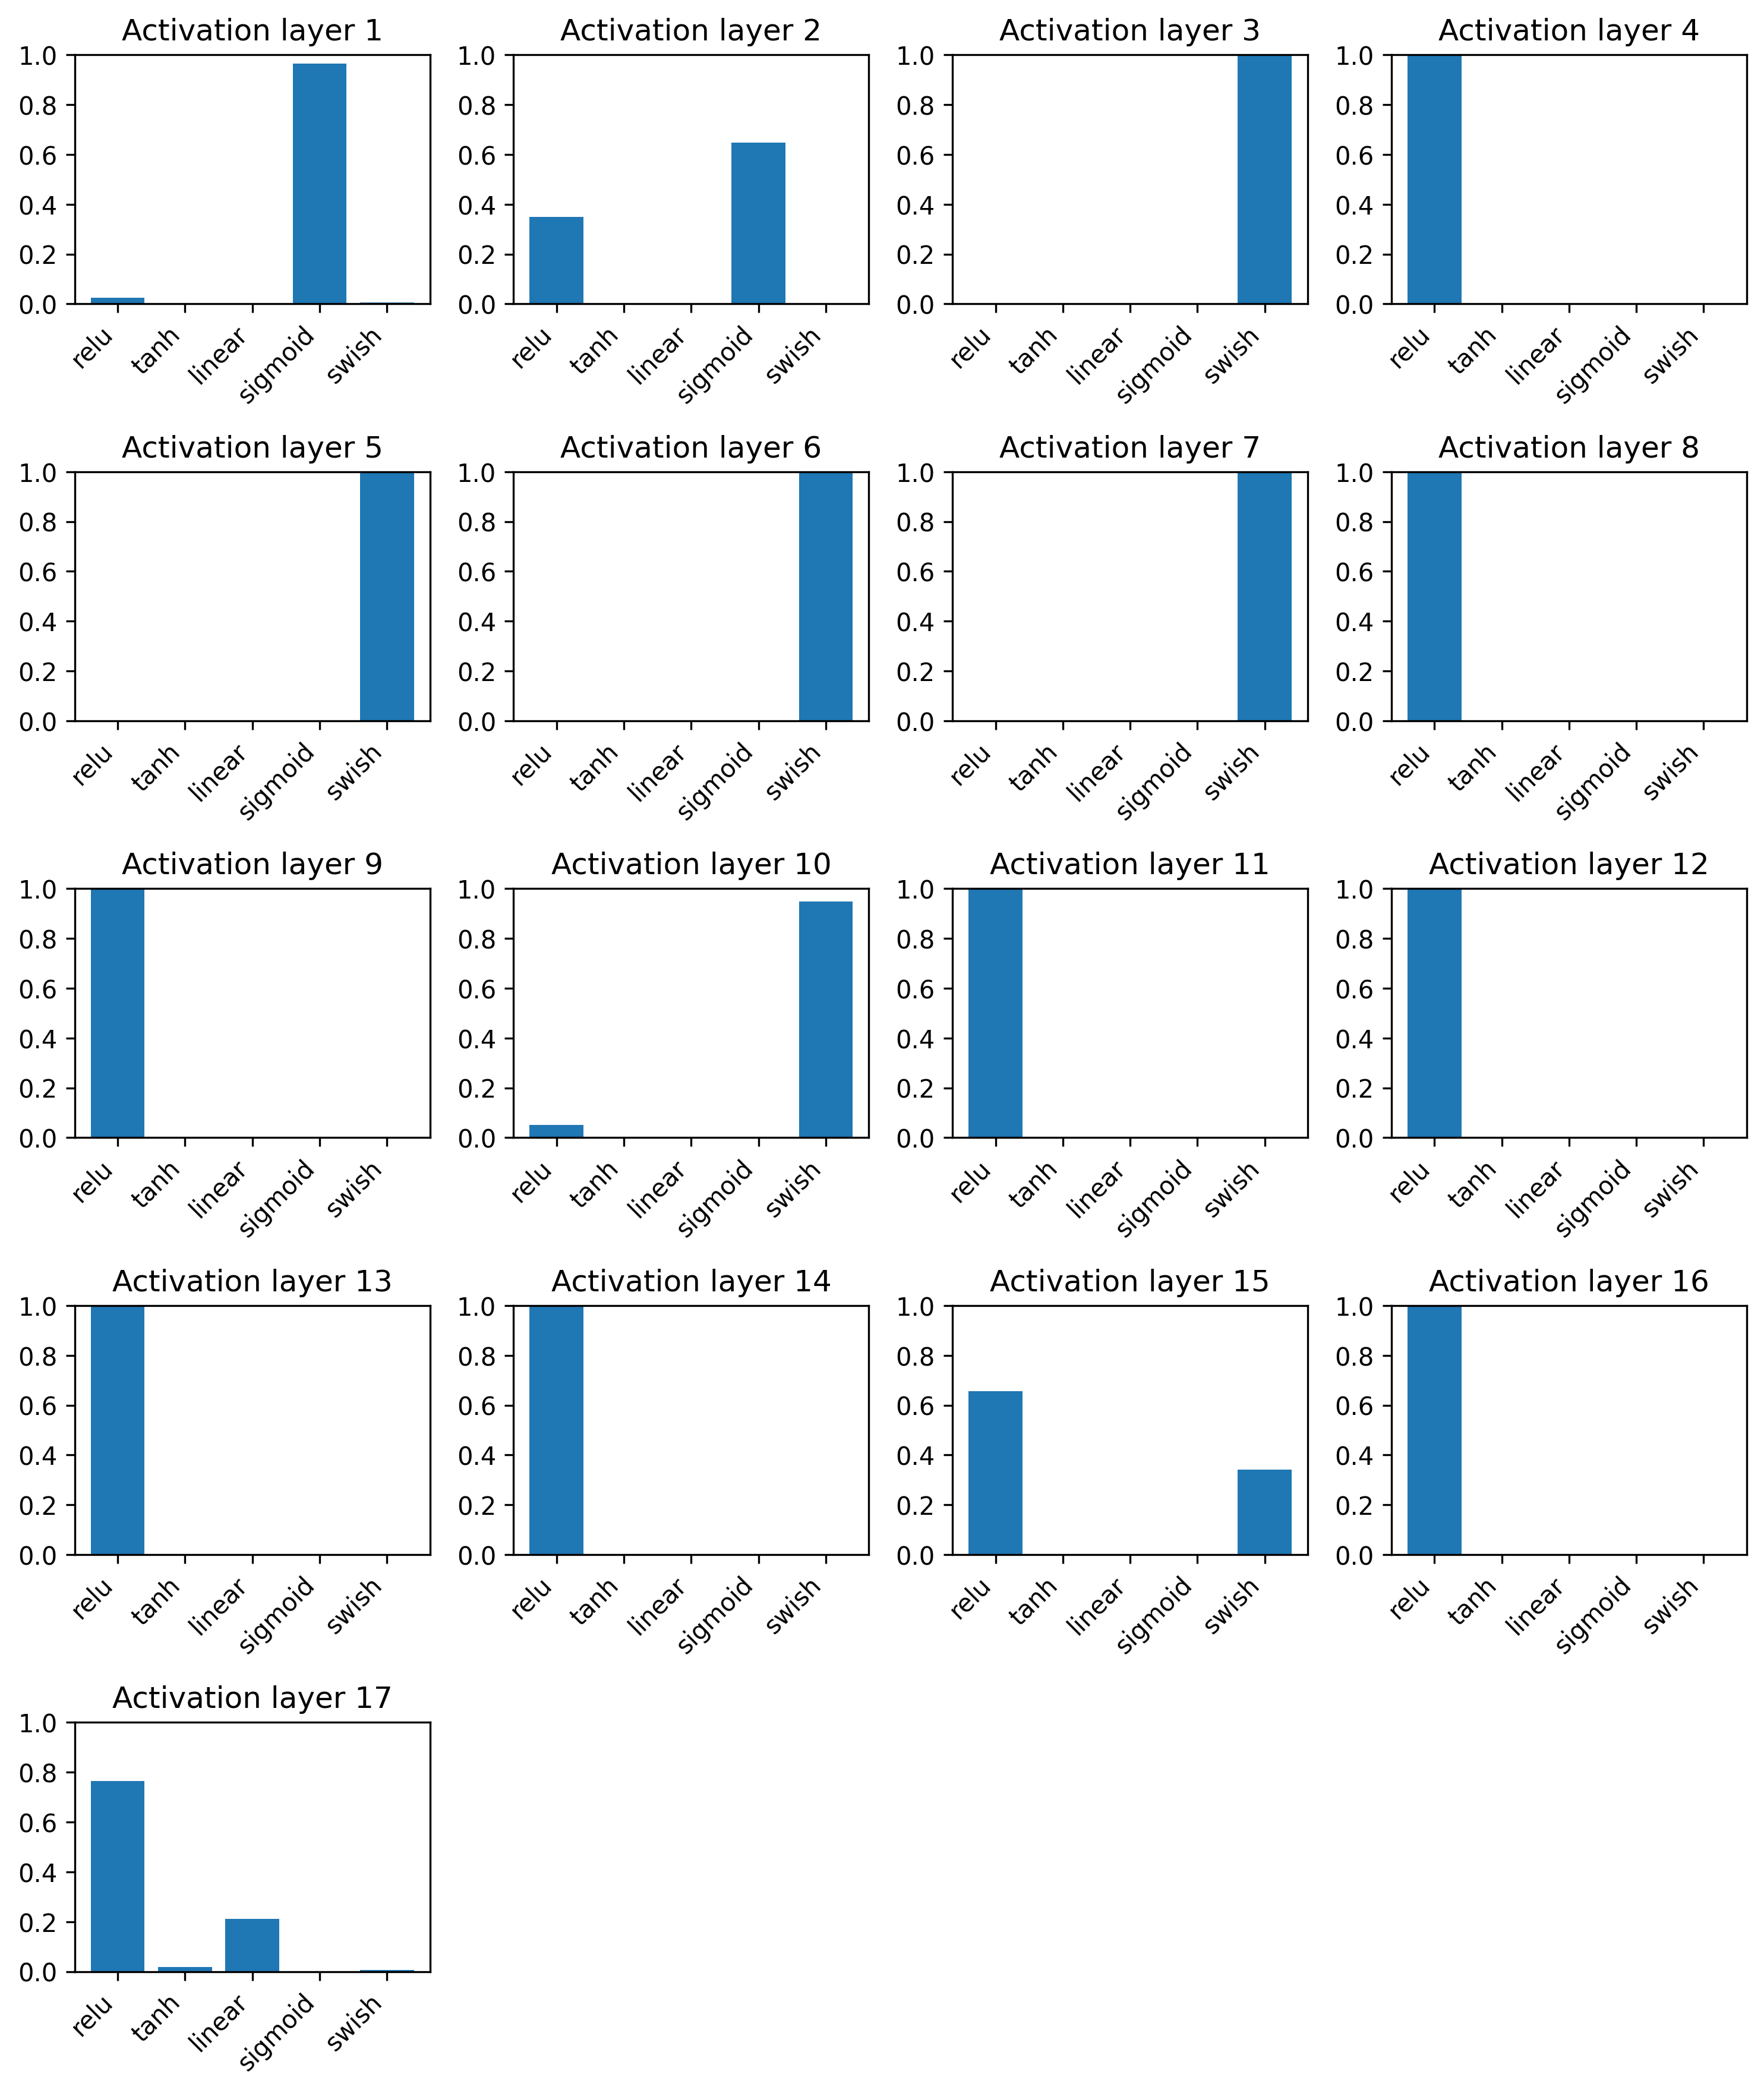

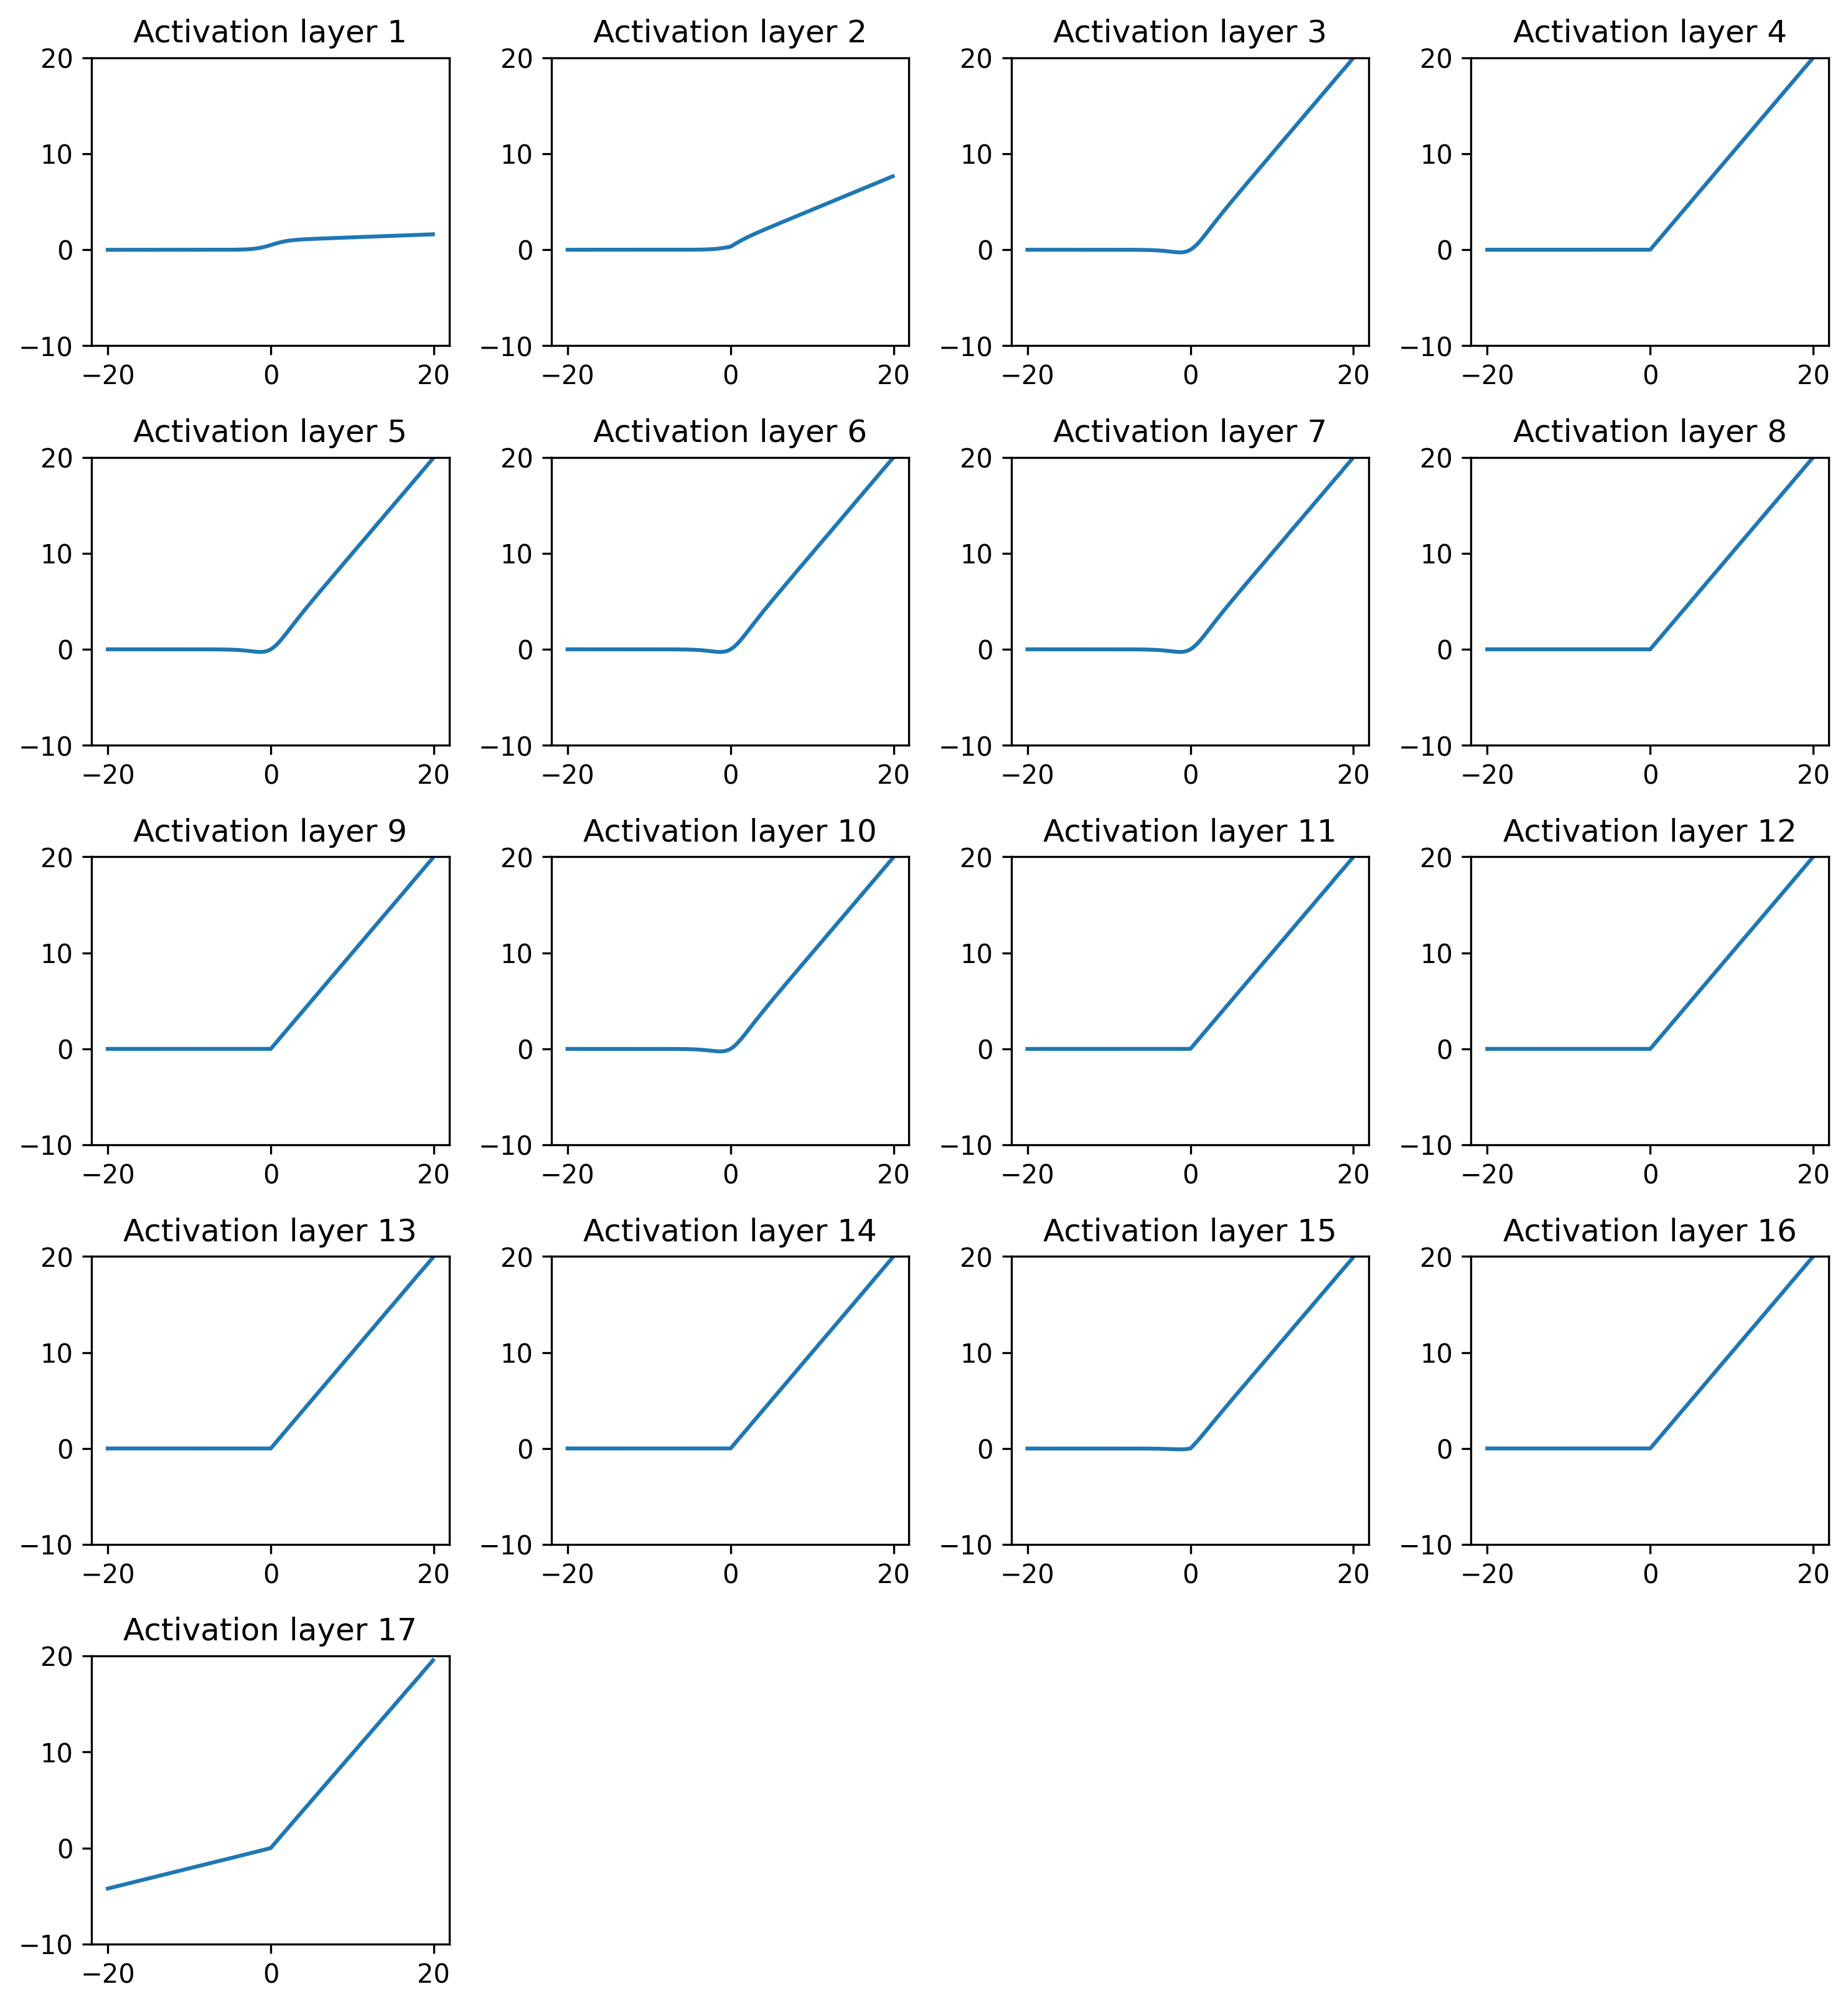

In [ ]:
plot_activation_functions_bars([model_layer_2.layers[3]], width=10, height=0.8, mode='grid')
plot_activation_functions([model_layer_2.layers[3]], width=10, height=0.75, mode='grid')